In [ ]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import *
# Tensorflow Stuff
import tensorflow.keras.initializers
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
from scipy import interpolate
import matplotlib.pyplot as plt
%matplotlib inline
import logging, os
logging.disable(logging.WARNING)
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18091814195970907107]

In [3]:
tf.test.is_gpu_available()


False

In [4]:
energies = np.linspace(1, 20000, 400)
i = 0
for energy in energies:
    if i % 100 == 0:
        print("\tEND \n\n\n\n\n\n \tSTART")
    print("neutron" , round(energy, 6), "keV 1000000")
    i += 1

	END 





 	START
neutron 1.0 keV 1000000
neutron 51.122807 keV 1000000
neutron 101.245614 keV 1000000
neutron 151.368421 keV 1000000
neutron 201.491228 keV 1000000
neutron 251.614035 keV 1000000
neutron 301.736842 keV 1000000
neutron 351.859649 keV 1000000
neutron 401.982456 keV 1000000
neutron 452.105263 keV 1000000
neutron 502.22807 keV 1000000
neutron 552.350877 keV 1000000
neutron 602.473684 keV 1000000
neutron 652.596491 keV 1000000
neutron 702.719298 keV 1000000
neutron 752.842105 keV 1000000
neutron 802.964912 keV 1000000
neutron 853.087719 keV 1000000
neutron 903.210526 keV 1000000
neutron 953.333333 keV 1000000
neutron 1003.45614 keV 1000000
neutron 1053.578947 keV 1000000
neutron 1103.701754 keV 1000000
neutron 1153.824561 keV 1000000
neutron 1203.947368 keV 1000000
neutron 1254.070175 keV 1000000
neutron 1304.192982 keV 1000000
neutron 1354.315789 keV 1000000
neutron 1404.438596 keV 1000000
neutron 1454.561404 keV 1000000
neutron 1504.684211 keV 1000000
neutron 1554.807018

In [5]:
import multiprocessing
from multiprocessing import Process
# Bins to use for light yield histograma
BINS = np.linspace(1.1, 30, 101)

# Change the bins so that they fall at the midpoint of each range, 
# instead of being the beginning and end points 
bins = np.zeros(len(BINS) - 1)
for i in range(0, len(BINS) - 1):
    bins[i] = (BINS[i + 1] + BINS[i]) / 2.0
bins = np.array(bins)

In [ ]:
len(bins)

In [ ]:
bins[0]

In [6]:
DATADIR = "./G4DataToLY/LY_Interp_Uncertain/"

manager = multiprocessing.Manager()
energyToLY = manager.dict()

def getLY(file, energy, returnDict):
    lightYields = np.load(DATADIR + file)
    counts = np.array(plt.hist(lightYields, bins = BINS)[0])
    returnDict[energy] = counts
    
threads = []
for file in os.listdir(DATADIR):
    energy = file[file.index("_") + 1:]
    energy = float(energy[0: energy.index("_")])
    threads.append(Process(target = getLY, args = (file, energy, energyToLY)))
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

keys = list(energyToLY.keys())
keys.sort()
energyToLY = dict(energyToLY)

In [7]:
# Gets the dimensions of the x and y data
xDim = len(bins)
yDim = len(keys)

# This is my attempt at multi-threading the random data generation
def loadRandomGaussianDataMT(num, outputNeurons):
    # Normalizes the data
    def normalize(bins, counts):
        width = bins[1] - bins[0]
        counts = counts / ( width * sum(counts) )
        return counts

    # Randomly adds a gaussian peak to a 1D array
    def addGaussian(data, i, count):
        # Randomly picks the width and height of the gaussian
        # ~8 is placeholder for typical width of peak in the real-world data (depends on detector resolution)
        H = np.random.normal(loc = 10 / count, scale = 5 / count)
        wLoc = len(data) * 0.1
        wScale = wLoc / 6
        W = int( np.abs(np.random.normal(loc = wLoc * count, scale = wScale * count))) + 1

        for k in range(-W, W + 1):
            if (i + k) >= len(data):
                break
            elif (i + k) < 0:
                continue
            else:
                data[i + k] += H * np.exp(- (2.5*k/W)**2)

    # Gets the detector response of a given neutron spectra
    def getX(yRow):
        xRow = np.zeros(xDim)
        for index in range(yDim):
            xRow += yRow[index] * energyToLY[keys[index]]        
        return normalize(bins, xRow)

    # interpolates the energy spectrum for training data
    # so that there only need to be N output neurons
    def interpY(energies, y, N):
        f = interpolate.interp1d(energies, y)
        newEnergies = np.linspace(np.min(energies), np.max(energies), N)
        return newEnergies, f(newEnergies)
    
    # Generates 100 data points and appends to a thread-safe dict
    def addXYtoQueue(count, queue, seed):
        np.random.seed(seed)
        x = np.zeros( (0, xDim) )
        y = np.zeros( (0, outputNeurons) )

        for _ in range(count):
            yRow = np.zeros(yDim)

            i = np.random.randint(low = 0, high = yDim + 1)
            addGaussian(yRow, i, 1)

            # Flip a coin and keep adding gaussian spikes
            p = np.random.random()
            nSpikes = 2
            while p > 0.4:
                i = np.random.randint(low = 0, high = yDim + 1)
                addGaussian(yRow, i, nSpikes)
                nSpikes += 1
                p = np.random.random()

            yRow = np.abs(yRow)
            xRow = getX(yRow)
            yRow = normalize(*interpY(keys, yRow, outputNeurons))

            x = np.vstack( (x, xRow) )
            y = np.vstack( (y, yRow) )   

        queue.put((x, y))
    
    threads = 100
    
    manager = Manager()
    queue = manager.Queue()
    
    numPerThread = num // threads
    
    proccesses = [Process(target = addXYtoQueue, args = (numPerThread, queue, int(1e9 * np.random.random())), daemon = True) for _ in range(threads)]
    
    for p in proccesses:
        p.start()
    for p in proccesses:
        p.join(timeout = 3)
        
    x = np.zeros( (0, xDim) )
    y = np.zeros( (0, outputNeurons) )
    
    while not queue.empty():
        xRow, yRow = queue.get()
        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )
   
    return x, y

In [ ]:
x,y = loadRandomGaussianDataMT(1000, 100)

In [14]:
# Gets input and output dimensions
inputDim = len(bins)
outputDim = 100
    
def bootstrapModel(numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2):
    
    error = []
    for _ in range(1):
        print("START")
        x,y = loadRandomGaussianDataMT(20000, outputDim)
        xVal, yVal = loadRandomGaussianDataMT(2000, outputDim)
        print("len" , len(x), " ", len(y))
        model = getModel(inputDim, outputDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2)
        model.compile(loss = "mse", optimizer = Adam() )

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-7, 
                                patience=1, verbose=0,
                                mode='min', restore_best_weights=True)

        with tf.device("/device:GPU:0"):
            model.fit(x, y * 1e4, validation_data = (xVal, yVal * 1e4), batch_size = 120, callbacks=[monitor], verbose=0, epochs=10000)
            
        xtest, ytest = xVal, yVal
        ypred = model(xtest)
        error.append( metrics.mean_squared_error(ytest * 1e4, ypred) )
        
    print( "Error : " , np.mean(error), " ± ", np.std(error) )
    return - np.mean( error )

def getModel(inputDim, outputDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2):
    
    numNeurons0 = int( numNeurons0 )
    numNeurons1 = int( numNeurons1 )
    numNeurons2 = int( numNeurons2 )
    
    dropout = 0.02
    
    model = keras.Sequential()
    model.add(keras.Input(inputDim))
    if numNeurons0 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons0, activation=keras.layers.LeakyReLU(alpha = alpha0)))
    if numNeurons1 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons1, activation=keras.layers.LeakyReLU(alpha = alpha1)))
    if numNeurons2 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons2, activation=keras.layers.LeakyReLU(alpha = alpha2)))
        
    model.add(Dense(outputDim, activation="relu"))
    return model
    
    

In [16]:
pbounds = {'numNeurons0' : (830,860),
           'numNeurons1' : (590,615), 
           'numNeurons2' : (610,640), 
           'alpha0' : (0.12, 0.18), 
           'alpha1' : (0.20, 0.24), 
           'alpha2' : (0.1, 0.18),
           }
optimizer = BayesianOptimization(
    f=bootstrapModel,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=5, n_iter=5)

print("Best Value : " , optimizer.max)
Best = optimizer.max

|   iter    |  target   |  alpha0   |  alpha1   |  alpha2   | numNeu... | numNeu... | numNeu... |
-------------------------------------------------------------------------------------------------
START
len 20000   20000
Error :  0.14098227793682633  ±  0.0
|  1        | -0.141    |  0.145    |  0.2288   |  0.1      |  839.1    |  593.7    |  612.8    |
START
len 20000   20000
Error :  0.0633033906734846  ±  0.0
|  2        | -0.0633   |  0.1312   |  0.2138   |  0.1317   |  846.2    |  600.5    |  630.6    |
START
len 20000   20000
Error :  0.1205747799545708  ±  0.0
|  3        | -0.1206   |  0.1323   |  0.2351   |  0.1022   |  850.1    |  600.4    |  626.8    |
START
len 20000   20000
Error :  0.09621575831818686  ±  0.0
|  4        | -0.09622  |  0.1284   |  0.2079   |  0.1641   |  859.0    |  597.8    |  630.8    |
START
len 20000   20000
Error :  0.08831051489566073  ±  0.0
|  5        | -0.08831  |  0.1726   |  0.2358   |  0.1068   |  831.2    |  594.2    |  636.3    |
START
len 2

In [17]:
Best = {'target': -0.0633033906734846, 'params': {'alpha0': 0.13117561268266026, 'alpha1': 0.21382242908172192, 'alpha2': 0.1317413979384536, 'numNeurons0': 846.1645020201007, 'numNeurons1': 600.4798628600823, 'numNeurons2': 630.5565850119028}}
alpha0 = Best['params']['alpha0']
alpha1 = Best['params']['alpha1']
alpha2 = Best['params']['alpha2']
numNeurons0 = Best['params']['numNeurons0']
numNeurons1 = Best['params']['numNeurons1']
numNeurons2 = Best['params']['numNeurons2']

inputDim = len(bins)
outputDim = 100

model = getModel(inputDim, outputDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2)

model.compile(loss = "mse", optimizer = Adam() )

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                        patience=3, verbose=0,
                        mode='min', restore_best_weights=True)

x,y = loadRandomGaussianDataMT(20000, outputDim)

print("Running . . .")

with tf.device("/device:GPU:0"):
    model.fit(x, y * 1e4, validation_split=0.1, batch_size = 120, callbacks=[monitor], verbose=0, epochs=10000)

Running . . .


In [18]:
xtest, ytest = loadRandomGaussianDataMT(2000, outputDim)
error = metrics.mean_squared_error(ytest * 1e4, model(xtest))
print(error)

0.10047126971561415


In [19]:
xtest, ytest = loadRandomGaussianDataMT(400, outputDim)
ytest = ytest * 1e4
energyBins = np.linspace(1, 20000, outputDim)
i = 0

Text(0, 0.5, 'Normalized dN/dE ($\\int \\phi(E)\\;dE $ = 1)')

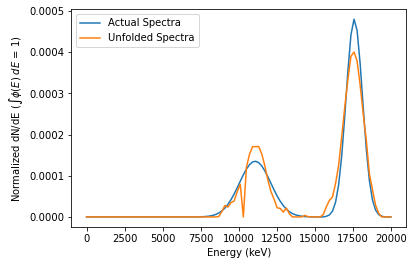

In [26]:
i += 1
plt.plot(energyBins, ytest[i] / 1e4, label = "Actual Spectra")
plt.plot(energyBins, model(xtest)[i] / 1e4, label = "Unfolded Spectra")
plt.legend()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized dN/dE ($\int \phi(E)\;dE $ = 1)")

(0.0, 31.0)

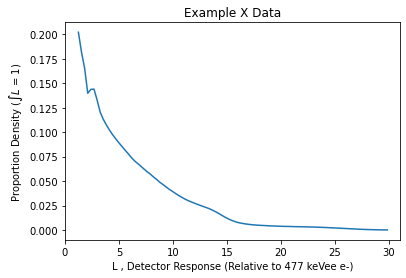

In [27]:
plt.plot(bins, xtest[10])
plt.xlabel("L , Detector Response (Relative to 477 keVee e-)")
plt.ylabel("Proportion Density ($\int L$ = 1)")
plt.title("Example X Data")
plt.xlim(0, 31)

Text(0, 0.5, 'Normalized dN/dE ($\\int \\phi(E)\\;dE $ = 1)')

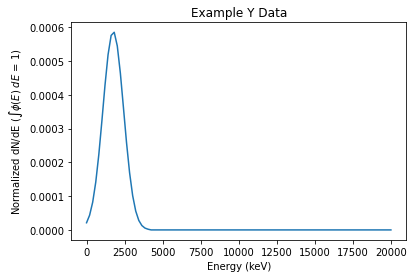

In [28]:
plt.plot(energyBins, ytest[1] / 1e4)
plt.title("Example Y Data")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized dN/dE ($\int \phi(E)\;dE $ = 1)")

In [29]:
def parseCSVstring(string):
    x, y = [], []
    
    while "\n" in string:
        i = string.index("\n")
        
        row = string[0 : i]
        x.append(float(row[0 : row.index(",")]))
        y.append(float(row[row.index(",") + 1 : ]))
        
        string = string[i + 1 : ]   
    x.append(float(string[0 : string.index(",")]))
    y.append(float(string[string.index(",") + 1 : ]))
    
    return np.array([x,y])
    

In [30]:
# Get the real-world data
string = """0.5128342857142856, 4559.028311330226
0.5378285714285713, 4273.328360316473
0.5628228571428571, 4070.8654373123277
0.5794857142857142, 3815.7571167227675
0.6044799999999999, 3576.635631423194
0.6378057142857143, 3352.499136777584
0.6627999999999998, 3245.754460882098
0.6794628571428571, 3042.3532474761396
0.6961257142857142, 2851.698547743237
0.72112, 2672.9915778015406
0.7461142857142857, 2546.349849767542
0.7711085714285713, 2386.7781213940902
0.8044342857142857, 2165.9728675151823
0.8377599999999998, 2030.238167072919
0.8627542857142856, 1903.009532971776
0.8877485714285713, 1783.753916813932
0.9210742857142855, 1671.9716746664524
0.9460685714285713, 1592.756542130266
0.971062857142857, 1492.9435041343083
0.9960571428571428, 1399.3854349866704
1.029382857142857, 1354.8285421684677
1.046045714285714, 1290.6391039394418
1.0627085714285713, 1229.490850518617
1.0793714285714284, 1171.2396958181105
1.1043657142857142, 1097.8417915127166
1.1376914285714284, 1029.0435027904173
1.1710171428571428, 964.5565862236585
1.1960114285714283, 904.1108616930105
1.221005714285714, 847.4530804165158
1.2543314285714284, 820.4698954207865
1.2876571428571426, 769.0536301724616
1.320982857142857, 720.859460392649
1.3543085714285712, 692.2840685334822
1.3876342857142856, 654.1714198344241
1.4292914285714284, 613.1765564911078
1.4459542857142853, 584.1253094356126
1.4709485714285713, 547.5200153037683
1.5042742857142855, 504.97220013390876
1.5375999999999996, 488.89371908429507
1.5625942857142856, 465.73077838370136
1.5792571428571425, 443.6652578399965
1.6042514285714284, 415.8621529291593
1.6375771428571426, 402.62096511060236
1.6625714285714281, 377.389976804753
1.6792342857142855, 359.5098909854878
1.6958971428571428, 342.47693277573467
1.7208914285714283, 326.2509667312869
1.7458857142857138, 326.2509667312869
1.7875428571428567, 321.0149816239511
1.8125371428571426, 300.89798338186654
1.8375314285714281, 282.0416540849658
1.8625257142857141, 277.51518197904966
1.8958514285714283, 264.3669915794367
1.9208457142857138, 247.79994452772397
1.954171428571428, 232.27110215645897
1.979165714285714, 221.26649817875096
1.9958285714285708, 210.78327334628233
2.020822857142857, 197.5741492178164
2.0541485714285708, 188.21342699198357
2.0874742857142854, 182.22064953142046
2.1374628571428564, 179.29619963091955
2.162457142857143, 168.06027128096824
2.1791199999999993, 157.5284631864664
2.1874514285714284, 150.06503645585101
2.220777142857142, 152.51270507256092
2.2457714285714285, 150.06503645585101
2.262434285714285, 142.95521400370373
2.2874285714285714, 133.99666081013916
2.320754285714285, 125.59951194086769
2.3540799999999997, 119.64882381879723
2.3874057142857135, 117.72858595436354
2.4124, 112.15080872226244
2.4290628571428563, 106.83729694955446
2.4540571428571427, 96.17243284681119
2.4873828571428565, 95.3975781389509
2.520708571428571, 100.14213990719263
2.554034285714285, 96.95358121358814
2.5873599999999994, 90.87780551934861
2.620685714285714, 89.41931225861104
2.654011428571428, 86.57217192645354
2.6790057142857133, 82.4705318227314
2.6956685714285706, 77.30236323661492
2.720662857142856, 72.45806750476758
2.7456571428571426, 69.02512931109206
2.7789828571428563, 66.82734647615338
2.8373028571428565, 64.17826199105252
2.862297142857142, 63.66118212758205
2.8789599999999993, 59.67173626910241
2.8956228571428566, 56.844592383327985
2.920617142857142, 53.28232074334886
2.9539428571428568, 52.00479317306002
2.9872685714285705, 49.141748213682696
3.012262857142857, 52.427195498229665
3.0372571428571424, 55.034641853049315
3.062251428571428, 54.15139369591062
3.0789142857142853, 50.75789633863406
3.0955771428571426, 46.8134969898195
3.120571428571428, 43.175617164964976
3.153897142857142, 40.79864909048764
3.1788914285714283, 39.82043721239215
3.1955542857142847, 37.93381361749319
3.203885714285714, 35.55662094568006
3.2288799999999993, 33.3283994544581
3.2455428571428566, 31.239813588947825
3.253874285714285, 29.759725133293887
3.2788685714285704, 29.282112824102832
3.3038628571428568, 27.89477685218001
3.3288571428571423, 28.812165690476064
3.362182857142856, 28.812165690476064
3.3788457142857142, 27.44709500273195
3.4038399999999998, 26.146699008398848
3.412171428571428, 28.34976071440226
3.4371657142857135, 30.738447415702424
3.4288342857142853, 29.759725133293887
3.46216, 28.812165690476064
3.4788228571428563, 27.44709500273195
3.4871542857142854, 25.936036844388376
3.520479999999999, 26.359072249071183
3.553805714285714, 25.936036844388376
3.5787999999999993, 25.727071971012208
3.5787999999999993, 24.114837367515996
3.5787999999999993, 22.972317989287056
3.603794285714285, 21.883929207492763
3.612125714285714, 20.512532261562228
3.612125714285714, 19.540683882565872
3.6371199999999995, 18.918502076480287
3.670445714285714, 18.46490118871702
3.6954399999999996, 19.227076444643554
3.712102857142857, 21.883929207492763
3.7370971428571425, 22.787231595841927
3.762091428571428, 21.18713769904843
3.762091428571428, 19.859406483232927
3.7787542857142853, 18.022176096751316
3.7870857142857135, 16.89278306025562
3.803748571428571, 16.092432151625477
3.812079999999999, 16.89278306025562
3.8370742857142854, 14.13870517610726
3.862068571428571, 12.62478806870363
3.870399999999999, 12.026647397269631
3.8953942857142847, 12.62478806870363
3.912057142857142, 13.688524149944172
3.9287199999999993, 14.841888226868681
3.953714285714285, 15.580043815547786
3.970377142857142, 14.722308149442105
4.003702857142857, 15.330000487838529
4.028697142857142, 15.330000487838529
4.04536, 13.91179381863046
4.053691428571428, 13.252677035818497
4.078685714285713, 13.252677035818497
4.095348571428571, 12.62478806870363
4.112011428571428, 11.833632347247883
4.112011428571428, 11.272975268557394
4.128674285714285, 9.745407417663092
4.1370057142857135, 8.98809118817025
4.170331428571428, 8.156586265738863
4.161999999999999, 7.896877874527536
4.195325714285714, 8.025681629219319
4.203657142857142, 7.522737428890168
4.203657142857142, 7.108584537159011
4.211988571428571, 6.717232204313582
4.2369828571428565, 8.631796734286016
4.228651428571428, 8.156586265738863
4.2869714285714275, 8.98809118817025
4.320297142857142, 9.134693416410702
4.345291428571428, 9.745407417663092
4.353622857142857, 9.208888803092906
4.370285714285713, 8.843841771605616
4.389725714285714, 10.065909282115648
4.3869485714285705, 9.28368683237667
4.411942857142856, 8.562250938896735
4.420274285714285, 8.156586265738863
4.445268571428571, 6.398981334754336
4.445268571428571, 5.997977320514336
4.445268571428571, 5.622102965359794
4.445268571428571, 5.269783472671909
4.445268571428571, 4.939542733378018
4.461931428571428, 4.705515723099428
4.4869257142857135, 4.339849797344677
4.511919999999999, 4.55569055378822
4.553577142857142, 4.743735676709178
4.5869028571428565, 5.35573742922001
4.611897142857142, 5.1852089867838025
4.628559999999999, 4.939542733378018
4.656331428571428, 4.339849797344677
4.645222857142857, 4.06788507375939
4.6868799999999995, 4.304883924616527
4.711874285714285, 4.20166755145813
4.7368685714285705, 4.0025997939088604
4.761862857142856, 5.443093356586195
4.761862857142856, 5.101991832501511
4.761862857142856, 4.782266067036163
4.761862857142856, 4.55569055378822
4.778525714285713, 6.82679509015268
4.778525714285713, 6.398981334754336
4.778525714285713, 6.095808642172527
4.803519999999999, 7.402005399990124
4.828514285714285, 7.770141284718341
4.845177142857142, 7.051311158168866
4.845177142857142, 6.609427687635257
4.845177142857142, 6.296284410032296
4.861839999999999, 5.997977320514336
4.878502857142856, 4.939542733378018
4.878502857142856, 4.6299971415138
4.878502857142856, 4.339849797344677
4.878502857142856, 4.06788507375939
4.878502857142856, 3.8129635231705694
4.878502857142856, 3.5740171035838033
4.903497142857142, 3.243378177891188
4.9368228571428565, 2.9433272701108324
4.961817142857142, 2.6710346261905276
4.97014857142857, 2.5036492954256016
4.97014857142857, 2.3467534763579625
4.97014857142857, 2.1996898243138285
4.97014857142857, 2.078589239551615
4.995142857142857, 3.3500447038339374
4.995142857142857, 3.1401079492407256
4.995142857142857, 2.9433272701108324
4.995142857142857, 2.758878216614442
4.995142857142857, 2.6281673278525806
5.020137142857142, 3.8129635231705694
5.020137142857142, 3.6323118916745663
5.045131428571428, 3.3500447038339374
5.045131428571428, 3.1401079492407256
5.045131428571428, 2.9433272701108324
5.045131428571428, 2.758878216614442
5.045131428571428, 2.6281673278525806
5.070125714285713, 2.1996898243138285
5.070125714285713, 2.0618421883405955
5.070125714285713, 1.9326330297260221
5.070125714285713, 1.8115210022906891
5.070125714285713, 1.6979986843159134
5.070125714285713, 1.591590452604598
5.070125714285713, 1.4918504897679936
5.070125714285713, 1.4097189252665991
5.095119999999999, 2.1996898243138285
5.103451428571428, 2.028751788333532
5.128445714285713, 1.9326330297260221
5.128445714285713, 1.8115210022906891
5.128445714285713, 1.6979986843159134
5.128445714285713, 1.591590452604598
5.128445714285713, 1.5161836436515976
5.145108571428571, 1.2689959643690352
5.145108571428571, 1.1894719824810835
5.145108571428571, 1.1149315181715032
5.145108571428571, 1.0450622700833407
5.145108571428571, 0.9955490232457505"""

UnprocessedCF252DetectorResponse = parseCSVstring(string)

string = """0.5211657142857142, 22803.926815418923
0.5711542857142857, 21899.96261645648
0.621142857142857, 20527.56090726441
0.6794628571428571, 19873.956611909678
0.7294514285714284, 18628.518320517458
0.7794399999999999, 17461.127725814637
0.8294285714285714, 16366.893824368562
0.9210742857142855, 14496.643866067088
0.9627314285714283, 13921.986388602614
1.0127199999999998, 13049.539332427752
1.0627085714285713, 12035.458801947228
1.1126971428571426, 11100.18253390867
1.162685714285714, 10404.569041380018
1.204342857142857, 9752.547456417738
1.2543314285714284, 9215.635757850501
1.3459771428571425, 8295.699501654655
1.4042971428571425, 7775.8341313613055
1.454285714285714, 7288.547087124287
1.5042742857142855, 7056.477349050641
1.554262857142857, 6614.270129599268
1.6042514285714284, 6199.774644383282
1.6625714285714281, 5906.0400210097905
1.7125599999999996, 5626.222037178435
1.7542171428571425, 5273.644415227813
1.804205714285714, 4943.161722819412
1.8625257142857141, 4708.963251066559
1.9125142857142852, 4485.8606987367275
1.9625028571428567, 4204.745931649515
2.012491428571428, 3941.247741977815
2.06248, 3754.5182255815557
2.112468571428571, 3519.234388790481
2.162457142857143, 3352.499136777584
2.2041142857142857, 3142.408570599122
2.2541028571428567, 2945.483718771779
2.304091428571428, 2805.9317833526416
2.3457485714285706, 2672.9915778015406
2.3957371428571426, 2505.4836110402525
2.462388571428571, 2348.472841188047
2.5040457142857138, 2329.5513562738106
2.562365714285714, 2201.3014419631136
2.612354285714285, 2063.3528109856798
2.662342857142857, 1997.6549783895432
2.7039999999999997, 1857.3818817926106
2.76232, 1812.8482254232747
2.812308571428571, 1755.1265412779603
2.862297142857142, 1671.9716746664524
2.920617142857142, 1645.1382866273236
2.970605714285714, 1542.0426496179682
3.020594285714285, 1445.4076916024464
3.0789142857142853, 1399.3854349866704
3.1372342857142854, 1354.8285421684677
3.1872228571428565, 1269.9257028578181
3.2288799999999993, 1190.343457185884
3.2788685714285704, 1115.7483803002308
3.3371885714285705, 1080.2225846543781
3.3955085714285707, 1045.8279420342003
3.4371657142857135, 1012.5284361550771
3.4871542857142854, 980.2891975027359
3.5288114285714283, 918.8575597544445
3.5787999999999993, 861.2756493376908
3.6287885714285713, 781.5974477038282
3.6787771428571423, 756.7111277281932
3.7287657142857134, 756.7111277281932
3.762091428571428, 697.9070579231974
3.812079999999999, 643.6726561182113
3.853737142857142, 613.1765564911078
3.903725714285714, 584.1253094356126
3.9453828571428566, 565.5265673348209
3.9870399999999995, 513.2086597101695
4.028697142857142, 481.0474887486653
4.078685714285713, 443.6652578399965
4.128674285714285, 422.64516358002186
4.161999999999999, 396.15932179857884
4.195325714285714, 365.3737557360282
4.278639999999999, 321.0149816239511
4.311965714285714, 296.06888700983166
4.361954285714285, 282.0416540849658
4.39528, 260.12417922963846
4.4369371428571425, 243.82301587017773
4.461931428571428, 228.54339509725696
4.495257142857142, 228.54339509725696
4.528582857142856, 207.40042335452844
4.570239999999999, 194.40329178476827
4.62022857142857, 194.40329178476827
4.67854857142857, 182.22064953142046
4.728537142857142, 188.21342699198357
4.761862857142856, 173.58734962438643
4.803519999999999, 158.80796811419347
4.861839999999999, 150.06503645585101
4.911828571428571, 145.2869163054246
4.945154285714285, 140.66093307317118
4.995142857142857, 131.84615524240397
5.02846857142857, 127.64813026604435
5.078457142857142, 117.72858595436354
5.128445714285713, 115.8391658893727
5.170102857142856, 113.06173941698299
5.178434285714284, 101.77553019483058
5.211759999999999, 92.36008785358585
5.245085714285714, 85.1827795594112
5.26174857142857, 76.06174155593749
5.295074285714285, 71.29519167895033
5.328399999999999, 63.66118212758205
5.361725714285713, 56.844592383327985
5.37838857142857, 51.58579411450832
5.395051428571428, 46.8134969898195
5.411714285714285, 42.48269388954675
5.453371428571428, 41.130030934123695
5.478365714285713, 39.18136104872391
5.511691428571428, 34.98597455157418
5.5366857142857135, 32.00723752654055
5.561679999999999, 28.812165690476064
5.578342857142856, 25.727071971012208
5.578342857142856, 22.972317989287056
5.595005714285714, 20.847106407890106
5.61166857142857, 18.614880002596454
5.644994285714285, 16.89278306025562
5.661657142857142, 15.08397009272897
5.661657142857142, 13.688524149944172
5.678319999999999, 12.222810661503368
5.678319999999999, 10.914040025824825
5.694982857142856, 9.745407417663092
5.703314285714285, 8.631796734286016
5.703314285714285, 7.8332532700816735
5.711645714285713, 7.402005399990124
5.736639999999999, 9.359092399149969
5.761634285714285, 8.562250938896735
5.7782971428571415, 7.645438683968066
5.794959999999999, 6.095808642172527
5.794959999999999, 5.531874121922281
5.811622857142856, 4.8602682642534
5.811622857142856, 4.410635867178608
5.828285714285713, 3.938362274181314
5.836617142857142, 3.5166578855706914
5.844948571428571, 3.1401079492407256
5.853279999999999, 2.803877503507751
5.861611428571427, 2.5036492954256016
5.861611428571427, 2.2355683465641
5.861611428571427, 1.996192454466655
5.869942857142856, 1.7969257015848357
5.8782742857142845, 1.670747590127807
5.894937142857142, 1.841068212024132
5.928262857142856, 2.1996898243138285
5.928262857142856, 2.095472316558333
5.928262857142856, 1.901616300908398
5.928262857142856, 1.670747590127807
5.944925714285713, 1.5161836436515976
5.944925714285713, 1.3538366445806616
5.953257142857142, 1.20887312555035
5.953257142857142, 1.0794317316846742
5.953257142857142, 0.9955490232457505
5.986582857142856, 1.2186920439213607
5.986582857142856, 1.088199278779962
5.986582857142856, 0.9955490232457505
6.003245714285713, 1.5039678558266651
6.003245714285713, 1.3213762784594087
6.011577142857142, 1.8710973579879182
6.011577142857142, 1.7824479942176323
6.011577142857142, 1.6439338473589413
6.011577142857142, 1.4211691881276913
6.01990857142857, 1.1703822073663515
6.0282399999999985, 1.2896942007475762
6.0282399999999985, 1.0117871434511303"""

UnprocessedAmBe241DetectorResponse = parseCSVstring(string)

UnprocessedCF252EnergySpectra = np.array([[0.10633417919187993,0.10203982041772397,0.08915674409525653,0.1278059730626584,0.1278059730626584,0.1149228967401914,0.1149228967401914,0.15786648448174923,0.14068904938512583,0.14068904938512583,0.14068904938512583,0.14068904938512583,0.18363263712668365,0.1793382783525277,0.1664552020300607,0.1664552020300607,0.20939878977161852,0.19222135467499513,0.19222135467499513,0.23516494241655295,0.21798750731992955,0.21798750731992955,0.2609310950614874,0.24375365996486442,0.28669724770642224,0.26951981260979885,0.31246340035135667,0.2952859652547337,0.3339351942221356,0.36399570564122596,0.346818270544603,0.38976185828616083,0.4112336521569393,0.43699980480187417,0.4627659574468086,0.492826468865899,0.5400644153816123,0.604479796993949,0.6817782549287528,0.7590767128635565,0.8363751707983607,0.9007905524106969,0.9523228577005662,1.0038551629904355,1.0553874682803048,1.1069197735701741,1.158452078860043,1.2099843841499123,1.257222330665626,1.291577200858872,1.3388151473745853,1.386053093890299,1.4161136053093895,1.4633515518251028,1.4934120632441932,1.5234725746632831,1.5664161624048414,1.5964766738239318,1.6351259027913336,1.6737751317587355,1.6995412844036704,1.7381905133710722,1.776839742338474,1.806900253757564,1.8498438414991218,1.8799043529182127,1.9099648643373026,1.9529084520788604,1.9829689634979504,2.021618192465353,2.060267421432755,2.090327932851845,2.1332715205934027,2.1633320320124927,2.2105699785282065,2.2406304899472973,2.28786843646301,2.317928947882101,2.36946125317197,2.4081104821393717,2.4338766347843066,2.545529962912357,2.588473550653914,2.627122779621316,2.7559535428459894,2.807485848135858,2.84613507710326,2.9620827640054657,3.0136150692953354,3.0651473745852043,3.116679679875074,3.168211985164943,3.2197442904548126,3.2583935194222144,3.348575053679485,3.400107358969355,3.4516396642592237,3.5031719695490926,3.5547042748389623,3.606236580128831,3.644885809096233,3.7608334959984386,3.8123658012883084,3.876781182900645,3.941196564512981,4.005611946125318,4.160208861994926,4.23750731992973,4.3148057778645335,4.392104235799337,4.443636541089206,4.5724673043138795,4.636882685926216,4.778596525473357,4.8430119070856925,4.958959593987899,5.036258051922703,5.216621120437245,5.3712180363068525,5.448516494241656,5.52581495217646,5.603113410111264,5.680411868046068,5.757710325980872,5.835008783915676,5.912307241850479,5.989605699785283,6.1699687682998245,6.24726722623463,6.324565684169434,6.4018641421042375,6.4533964473941055,6.556461057973845,6.633759515908649,6.968719500292799,7.046017958227603,7.123316416162407,7.2006148740972105,7.277913332032014,7.612873316416163,8.038014835057584,8.231260979894595,8.77235018543822,8.849648643373024,8.92694710130783,9.004245559242634,9.081544017177437,9.158842475112241,9.236140933047045,9.571100917431194,9.648399375365997,9.725697833300803,9.802996291235607,9.854528596525475,10.137956275619755],[0.9133874949338638,0.8959599867359345,0.8777218967613573,0.9798552006189897,0.9664806013042997,0.9506742566596661,0.9360837846800044,1.0511863969640027,1.0382170885376367,1.023626616557975,1.0090361445783134,0.9944456725986515,1.1176541026491287,1.1002265944511993,1.0868519951365094,1.0722615231568475,1.1687207545779448,1.154940864374931,1.1403503923952691,1.2197874065067609,1.2035757709738033,1.1889852989941416,1.2595059135625069,1.2424836962529016,1.2959820935116613,1.2813916215319994,1.3324582734608157,1.3154360561512104,1.3555598540952802,1.383524925389632,1.36893445340997,1.4062212151357725,1.428512213993589,1.4431026859732508,1.4589090306178845,1.474310084374194,1.4953852105670387,1.5124074278766442,1.521323827419771,1.5221344091964186,1.5140285914299398,1.5038963192218415,1.4917375925721235,1.4771471205924616,1.461340775947828,1.4467503039681662,1.4272963413286173,1.4078423786890681,1.3867672524962233,1.3705556169632658,1.3543439814303084,1.3332688552374636,1.317867801481154,1.2992244206182528,1.2838233668619432,1.2684223131056336,1.2505895140193801,1.2351884602630707,1.2181662429534652,1.2011440256438597,1.186553553664198,1.1695313363545927,1.154940864374931,1.1371080652886776,1.1192752662024243,1.1038742124461147,1.088473158689805,1.0706403596035519,1.055239305847242,1.0382170885376367,1.023626616557975,1.0057938174717216,0.9879610183854683,0.9725599646291588,0.9539165837662575,0.938515530009948,0.9198721491470468,0.9044710953907372,0.8874488780811318,0.8679949154415828,0.853404443461921,0.8128753546295272,0.8023377915331049,0.7792362108986404,0.7318171769647397,0.7123632143251906,0.6977727423455289,0.6588648170664309,0.6430584724217971,0.62482038244722,0.6090140378025863,0.591991820492981,0.5761854758483473,0.5664584945285729,0.5384934232342211,0.5239029512545594,0.5093124792748978,0.49472200729523585,0.481347407980546,0.4679728086658561,0.45702995468110963,0.43028075605172966,0.4169061567370398,0.4035315574223499,0.3877252127777162,0.37435061346302634,0.34273792417375915,0.32814745219409747,0.31517814376773123,0.3013982535647175,0.29167127224494305,0.2722173096053939,0.26005858295567585,0.24060462031612673,0.23209351166132408,0.2162871670166906,0.20737076747356387,0.1846744777274234,0.16927342397111356,0.16197818798128272,0.15468295199145188,0.14819829777826898,0.14090306178843814,0.13441840757525503,0.12874433513871986,0.12307026270218469,0.1190173538189454,0.10523746361593167,0.10037397295604444,0.095510482296157,0.09145757341291749,0.08983640985962182,0.08335175564643893,0.08010942853984737,0.06470837478353753,0.06146604767694619,0.059034302347002576,0.05579197524041102,0.05498139346376307,0.04120150326074934,0.03147452194097489,0.02661103128108744,0.021747540621200212,0.021747540621200212,0.020126377067904544,0.018505213514608654,0.016884049961312986,0.016884049961312986,0.016884049961312986,0.01202055930142576,0.01202055930142576,0.01202055930142576,0.01202055930142576,0.01202055930142576,0.01202055930142576]])
UnprocessedAmBe241EnergySpectra = np.array([[0.2702231319188191,0.3340059963099631,0.3467625691881919,0.42330200645756455,0.4998414437269372,0.5636243081180812,0.5636243081180812,0.5636243081180812,0.5636243081180812,0.5593721171586716,0.6018940267527675,0.6784334640221401,0.754972901291513,0.7677294741697416,0.7677294741697416,0.763477283210332,0.8059991928044281,0.8825386300738007,0.9590780673431734,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,0.9973477859778597,1.0050017297047968,1.0101043588560885,1.0866437961254611,1.1631832333948338,1.2014529520295203,1.2014529520295203,1.2091068957564572,1.2142095249077491,1.2907489621771218,1.3672883994464944,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4183146909594098,1.4948541282287824,1.571393565498155,1.62241985701107,1.6415547163284132,1.7244724400369003,1.8010118773062729,1.8520381688191883,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.8265250230627306,1.9285776060885609,2.0051170433579335,2.056143334870849,2.04338676199262,2.04338676199262,2.04338676199262,2.056143334870849,2.1326827721402215,2.209222209409594,2.2857616466789668,2.273005073800738,2.273005073800738,2.3623010839483394,2.426083948339483,2.56640625,2.6429456872693726,2.6684588330258303,2.681215405904059,2.681215405904059,2.681215405904059,2.681215405904059,2.681215405904059,2.681215405904059,2.681215405904059,2.6939719787822876,2.7705114160516606,2.8470508533210332,2.8853205719557193,2.8853205719557193,2.8895727629151287,2.974616582103321,3.051156019372694,3.1149388837638377,3.1149388837638377,3.1149388837638377,3.1149388837638377,3.1213171702029516,3.153208602398524,3.2297480396678964,3.3062874769372694,3.3190440498154983,3.3190440498154983,3.3190440498154983,3.3190440498154983,3.3190440498154983,3.357313768450185,3.421096632841328,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5486623616236166,3.5614189345018445,3.6379583717712176,3.7144978090405907,3.791037246309963,3.867576683579336,3.944116120848708,3.956872693726937,3.956872693726937,3.964526637453875,4.046168703874539,4.122708141143911,4.199247578413284,4.275787015682657,4.352326452952029,4.403352744464945,4.390596171586716,4.390596171586716,4.390596171586716,4.403352744464945,4.403352744464945,4.479892181734317,4.55643161900369,4.607457910516605,4.5947013376383765,4.607457910516605,4.760536785055351,4.837076222324723,4.824319649446494,4.824319649446494,4.824319649446494,4.824319649446494,4.913615659594096,4.990155096863469,5.049685770295203,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.041181388376383,5.168747117158672,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.245286554428044,5.372852283210332,5.449391720479705,5.474904866236162,5.474904866236162,5.474904866236162,5.474904866236162,5.50041801199262,5.50041801199262,5.576957449261992,5.640740313653136,5.691766605166052,5.691766605166052,5.691766605166052,5.691766605166052,5.704523178044281,5.781062615313653,5.832088906826568,5.908628344095941,5.908628344095941,5.908628344095941,5.908628344095941,5.908628344095941,5.927763203413284,6.010680927121771,6.087220364391144,6.138246655904059,6.12549008302583,6.12549008302583,6.12549008302583,6.12549008302583,6.138246655904059,6.138246655904059,6.214786093173432,6.291325530442804,6.367864967712177,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.342351821955719,6.44440440498155,6.520943842250922,6.559213560885609,6.559213560885609,6.559213560885609,6.559213560885609,6.571970133763838,6.571970133763838,6.64850957103321,6.725049008302583,6.763318726937269,6.763318726937269,6.763318726937269,6.763318726937269,6.763318726937269,6.776075299815498,6.776075299815498,6.8526147370848705,6.9291541743542435,6.999315325184502,7.082233048892989,7.158772486162361,7.209798777675276,7.197042204797048,7.209798777675276,7.286338214944649,7.3628776522140225,7.413903943726938,7.401147370848708,7.401147370848708,7.401147370848708,7.401147370848708,7.401147370848708,7.401147370848708,7.401147370848708,7.413903943726938,7.490443380996309,7.566982818265682,7.618009109778598,7.637143969095941,7.720061692804428,7.796601130073801,7.834870848708487,7.834870848708487,7.847627421586715,7.847627421586715,7.924166858856088,8.000706296125461,8.064489160516604,8.064489160516604,8.064489160516604,8.064489160516604,8.072143104243542,8.153785170664207,8.230324607933579,8.281350899446494,8.281350899446494,8.281350899446494,8.281350899446494,8.306864045202952,8.383403482472325,8.43442977398524,8.472699492619926,8.485456065498155,8.561995502767527,8.625778367158672,8.919179543357933,8.970205834870848,9.046745272140221,9.114780327490775,9.17431100092251,9.250850438191883,9.327389875461254,9.314633302583026,9.314633302583026,9.310381111623615,9.403929312730627,9.48046875,9.557008187269373,9.544251614391143,9.544251614391143,9.544251614391143,9.633547624538744,9.710087061808117,9.773869926199263,9.773869926199263,9.773869926199263,9.78662649907749,9.837652790590406,9.990731665129152,9.990731665129152,10.016244810885608,10.092784248154981,10.169323685424354,10.194836831180812,10.194836831180812,10.194836831180812,10.213971690498155,10.296889414206642,10.373428851476014,10.398941997232471,10.40744637915129,10.449968288745387,10.52650772601476,10.590290590405903,10.611551545202952,10.807152329335793],[0.22831415736517613,0.22729997020467096,0.22425740872315553,0.22375031514290297,0.22375031514290297,0.22273612798239784,0.2196935665008824,0.21665100501936696,0.21360844353785152,0.2100587884760835,0.20836847654190827,0.20853750773532578,0.20819944534849072,0.2049878526735578,0.20194529119204235,0.19822660493685682,0.19619823061584654,0.19586016822901148,0.1955221058421764,0.1918034195869909,0.18876085810547547,0.18571829662396003,0.1826757351424446,0.17963317366092915,0.17659061217941371,0.17354805069789828,0.17050548921638284,0.1674629277348674,0.16442036625335196,0.1602621988952809,0.19484598106850634,0.15985652403107883,0.15968749283766132,0.1563068689693108,0.15326430748779538,0.14910614012972428,0.15934943045082625,0.14870046526552222,0.1485314340721047,0.12266966147922351,0.1471791845247645,0.14413662304324906,0.14109406156173362,0.13805150008021821,0.13500893859870278,0.13196637711718734,0.1289238156356719,0.12588125415415646,0.12233159909238844,0.12216256789897093,0.12081031835163072,0.11650002291948386,0.11624647612935757,0.11641550732277511,0.15005271481286242,0.1471791845247645,0.14413662304324906,0.14109406156173362,0.13805150008021821,0.13500893859870278,0.13196637711718734,0.1289238156356719,0.12588125415415646,0.12283869267264103,0.11979613119112559,0.15022174600627994,0.150559808393115,0.16357521028626434,0.1603636176113314,0.15732105612981595,0.1542784946483005,0.1512359331667851,0.1639132726730994,0.1639132726730994,0.1708435516032179,0.1674629277348674,0.16467391304347825,0.171519676376888,0.171519676376888,0.18521120304370745,0.18538023423712496,0.2100587884760835,0.20701622699456806,0.20397366551305263,0.2009311040315372,0.19788854255002178,0.19484598106850634,0.1918034195869909,0.18876085810547547,0.1862253902042126,0.24200568403199557,0.24200568403199557,0.2506262748962893,0.24758371341477386,0.24386502715958835,0.2744596731681602,0.2744596731681602,0.27395257958790764,0.2709100181063922,0.26786745662487677,0.2648248951433613,0.2607681465013408,0.2595004125507093,0.2597539593408356,0.2590778345671655,0.255697210698815,0.25265464921729963,0.24961208773578417,0.24656952625426873,0.24378051156287958,0.2399773097109853,0.23947021613073272,0.23845602897022758,0.23541346748871214,0.23287799958744929,0.22729997020467096,0.22425740872315553,0.22121484724164012,0.21817228576012468,0.21512972427860924,0.2120871627970938,0.20904460131557837,0.20566397744722786,0.2049878526735578,0.2051568838669753,0.20549494625381035,0.20549494625381035,0.2051568838669753,0.20194529119204235,0.19890272971052692,0.19474456235245582,0.19433888748825376,0.19433888748825376,0.19501501226192386,0.1953530746487589,0.1953530746487589,0.21225619399051132,0.20904460131557837,0.2065091334143155,0.2009311040315372,0.19788854255002178,0.1953530746487589,0.21310134995759894,0.21327038115101646,0.2213838784350576,0.21817228576012468,0.21411553711810408,0.22222903440214525,0.23947021613073272,0.23338509316770184,0.2303425316861864,0.22729997020467096,0.2232432215626504,0.2399773097109853,0.2399773097109853,0.23845602897022758,0.2323709060071967,0.22932834452568127,0.22628578304416583,0.2232432215626504,0.22020066008113495,0.21715809859961951,0.21411553711810408,0.21107297563658867,0.20803041415507323,0.2049878526735578,0.20194529119204235,0.1994098232907795,0.1994098232907795,0.19890272971052692,0.19281760674749604,0.1897750452659806,0.18673248378446516,0.18368992230294973,0.1806473608214343,0.17760479933991885,0.17456223785840344,0.171519676376888,0.16847711489537257,0.16594164699410968,0.16492745983360454,0.16475842864018703,0.16137780477183655,0.15884233687057367,0.13298056427769248,0.12993800279617704,0.12655737892782654,0.16442036625335196,0.12638834773440905,0.1266418945245353,0.11573938254910499,0.11269682106758955,0.10965425958607417,0.10661169810455873,0.10407623020329582,0.10407623020329582,0.10407623020329582,0.09646982649950725,0.09342726501799181,0.09038470353647637,0.08734214205496094,0.0842995805734455,0.07986251174623549,0.07922864477091979,0.07956670715775482,0.1017097934954505,0.09241307785748665,0.08937051637597121,0.08632795489445583,0.08328539341294039,0.09849820082051752,0.08024283193142495,0.10204785588228554,0.10255494946253813,0.14489726341362794,0.1421082487222388,0.13906568724072335,0.1360231257592079,0.13298056427769248,0.12993800279617704,0.1268954413146616,0.12385287983314616,0.12081031835163072,0.11776775687011531,0.11472519538859988,0.11168263390708444,0.108640072425569,0.10559751094405356,0.10306204304279071,0.14616499736425936,0.1458269349774243,0.1421082487222388,0.13906568724072335,0.1360231257592079,0.13298056427769248,0.13044509637642962,0.14515081020375423,0.13044509637642962,0.1302760651830121,0.1268954413146616,0.12385287983314616,0.12081031835163072,0.11776775687011531,0.11472519538859988,0.11202069629391948,0.12993800279617704,0.11168263390708444,0.11185166510050193,0.11345746143796842,0.1142181018083473,0.11438713300176478,0.12097934954504824,0.11776775687011531,0.11523228896885246,0.1213174119318833,0.12148644312530082,0.1462917707593225,0.1421082487222388,0.13906568724072335,0.1360231257592079,0.13298056427769248,0.12993800279617704,0.1268954413146616,0.12385287983314616,0.12081031835163072,0.14768627810501708,0.14751724691159956,0.14616499736425936,0.1418547019321125,0.1416011551419862,0.1414321239485687,0.13805150008021821,0.13500893859870278,0.13107896335174532,0.14109406156173362,0.13044509637642962,0.13044509637642962,0.12993800279617704,0.1268954413146616,0.12385287983314616,0.12081031835163072,0.11655073227750912,0.11573938254910499,0.1155703513556875,0.11472519538859988,0.11066844674657927,0.09241307785748665,0.08937051637597121,0.08582086131420325,0.08531376773395066,0.08531376773395066,0.06604421168435287,0.06300165020283749,0.06249455662258491,0.06249455662258491,0.04221081341248201,0.0340973161284408,0.0340973161284408,0.03511150328894597,0.03713987760995624,0.03713987760995624,0.04791561619032342,0.0437320941532397,0.04068953267172426,0.037477939996791276,0.04931012353601799,0.04931012353601799,0.0601281199147396,0.056916527239806614,0.053873965758291176,0.049817217116270573,0.06046618230157458,0.06046618230157458,0.05945199514106947,0.05640943365955403,0.053366872178038594,0.050324310696523156,0.049817217116270573,0.046774655634755136,0.0437320941532397,0.04119662625197684,0.04119662625197684,0.041027595058559296,0.03764697119020882,0.034604409708693384,0.03156184822717795,0.027124779399967935,0.026490912424652235,0.025983818844399653,0.022434163782631633,0.018715477527446123,0.01685613439985334,0.01685613439985334,0.01660258760972705,0.012123260984162665,0.008066512342142063]])


In [31]:
DATADIR1 = "./G4DataToLY/New_LY_Interp_Uncertain/"

manager = multiprocessing.Manager()
energyToLY1 = manager.dict()

def getLY(file, energy, returnDict):
    lightYields = np.load(DATADIR1 + file)
    counts = np.array(plt.hist(lightYields, bins = BINS)[0])
    returnDict[energy] = counts
    
threads = []
for file in os.listdir(DATADIR1):
    energy = file[file.index("_") + 1:]
    energy = float(energy[0: energy.index("_")])
    threads.append(Process(target = getLY, args = (file, energy, energyToLY1)))
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

keys1 = list(energyToLY1.keys())
keys1.sort()

In [32]:
DATADIR2 = "./G4DataToLY/LY_Interp_Uncertain/"

manager = multiprocessing.Manager()
energyToLY2 = manager.dict()

def getLY(file, energy, returnDict):
    lightYields = np.load(DATADIR2 + file)
    counts = np.array(plt.hist(lightYields, bins = BINS)[0])
    returnDict[energy] = counts
    
threads = []
for file in os.listdir(DATADIR2):
    energy = file[file.index("_") + 1:]
    energy = float(energy[0: energy.index("_")])
    threads.append(Process(target = getLY, args = (file, energy, energyToLY2)))
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

keys2 = list(energyToLY2.keys())
keys2.sort()

In [33]:
# Normalizes the data
def normalize(bins,counts):
    width = bins[1] - bins[0]
    counts = counts / ( width * sum(counts) )
    return counts

# Gets the simulated detector response from a given energy spectra
def getX(yRow, energyToLY, keys):
    xRow = np.zeros(xDim)
    for index in range(yDim):
        xRow += yRow[index] * energyToLY[keys[index]]        
    return normalize(bins,xRow)

# Process CF252 Data

# Energy Spectra
CF252ESfunc = interpolate.interp1d(*UnprocessedCF252EnergySpectra,fill_value=0,bounds_error=False)
energies = np.linspace(1,20000,100)
CF252EnergySpectra = normalize(energies,CF252ESfunc(energies / 1000.0))

yCF252 = interpolate.interp1d(*UnprocessedCF252EnergySpectra, fill_value='extrapolate', bounds_error=False)(np.linspace(1,20000,400) / 1000)
yCF252 = [y if y > 0 else 0 for y in yCF252]
yCF252 = yCF252 / sum(yCF252)

# Detector Response
UnprocessedCF252DTfunc = interpolate.interp1d(*UnprocessedCF252DetectorResponse,fill_value='extrapolate',bounds_error=False)
x = np.linspace(0, max(UnprocessedCF252DetectorResponse[0]), 20000)
CF252DTfunc = interpolate.interp1d(x, UnprocessedCF252DTfunc(x), fill_value=0, bounds_error=False)
CF252DetectorResponse = normalize(bins,CF252DTfunc(bins * (477.0 / 1000.0)))

#Process AmBe241 Data

# Energy Spectra
AmBe241ESfunc = interpolate.interp1d(*UnprocessedAmBe241EnergySpectra,fill_value=0,bounds_error=False)
energies = np.linspace(1,20000,100)
AmBe241EnergySpectra = normalize(energies,AmBe241ESfunc(energies / 1000.0)) # Divide by 1000 because paper uses MeV

yAmBe241 = interpolate.interp1d(*UnprocessedAmBe241EnergySpectra, fill_value='extrapolate', bounds_error=False)(np.linspace(1,20000,400) / 1000)
yAmBe241 = [y if y > 0 else 0 for y in yAmBe241]
yAmBe241 = yAmBe241 / sum(yAmBe241)

# Detector Response
UnprocessedAmBe241DTfunc = interpolate.interp1d(*UnprocessedAmBe241DetectorResponse,fill_value='extrapolate',bounds_error=False)
x = np.linspace(0, max(UnprocessedAmBe241DetectorResponse[0]), 20000)
AmBe241DTfunc = interpolate.interp1d(x, UnprocessedAmBe241DTfunc(x), fill_value=0, bounds_error=False)
AmBe241DetectorResponse = normalize(bins,AmBe241DTfunc(bins * (477.0 / 1000.0)))


Text(0.5, 1.0, 'Real-World Detector Response, interpolated into 100 buckets')

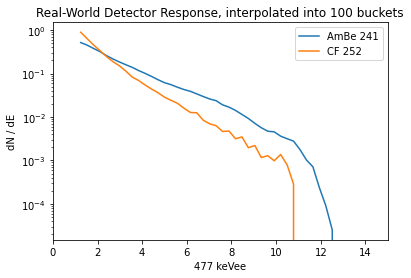

In [34]:
plt.plot(bins, AmBe241DetectorResponse, label="AmBe 241")
plt.plot(bins, CF252DetectorResponse, label="CF 252")
plt.yscale("log")
plt.legend()
plt.xlim(0, 15)
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.title("Real-World Detector Response, interpolated into 100 buckets")

Text(0, 0.5, 'counts')

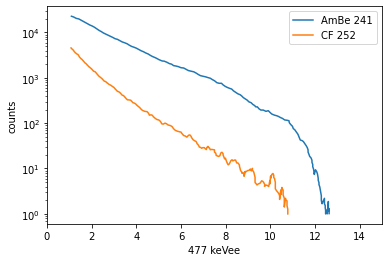

In [35]:
plt.plot( (1000 / 477) * UnprocessedAmBe241DetectorResponse[0],UnprocessedAmBe241DetectorResponse[1], label="AmBe 241")
plt.plot( (1000 / 477) * UnprocessedCF252DetectorResponse[0],UnprocessedCF252DetectorResponse[1], label="CF 252")
plt.yscale("log")
plt.legend()
plt.xlim(0, 15)
plt.xlabel("477 keVee")
plt.ylabel("counts")

In [36]:
min( (1000 / 477) * UnprocessedAmBe241DetectorResponse[0])

1.0925905959868223

In [37]:
min( bins )

1.2445

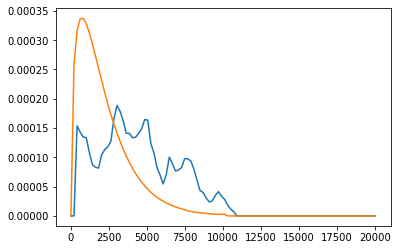

In [38]:
plt.plot(energies, AmBe241EnergySpectra, label="AmBe 241")
plt.plot(energies, CF252EnergySpectra, label="CF 252")

Text(0.5, 1.0, 'Actual Detector Response vs Simulation for CF 252')

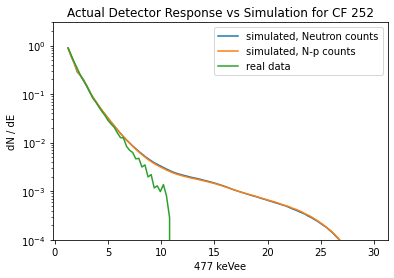

In [39]:
plt.plot(bins, getX(yCF252, energyToLY1, keys1), label = "simulated, Neutron counts")
plt.plot(bins, getX(yCF252, energyToLY2, keys2), label = "simulated, N-p counts")
plt.plot(bins, CF252DetectorResponse, label = "real data")
plt.yscale("log")
plt.legend()
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.ylim(1e-4, 3e0)
plt.title("Actual Detector Response vs Simulation for CF 252")

In [40]:
len(bins)

100

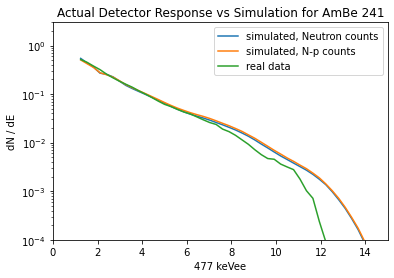

In [41]:
plt.plot(bins, getX(yAmBe241, energyToLY1, keys1), label = "simulated, Neutron counts")
plt.plot(bins, getX(yAmBe241, energyToLY2, keys2), label = "simulated, N-p counts")
plt.plot(bins, AmBe241DetectorResponse, label = "real data")
plt.yscale("log")
plt.ylim(1e-4, 3e0)
plt.xlim(0,15)
plt.xlabel("477 keVee")
plt.ylabel("dN / dE")
plt.title("Actual Detector Response vs Simulation for AmBe 241")
plt.legend()

Text(0.5, 1.0, 'Performance of NN on CF 252')

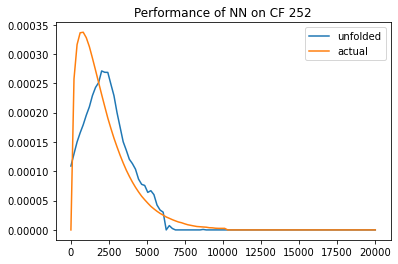

In [42]:
plt.plot(energies, model(np.array([CF252DetectorResponse]))[0] / 1e4, label = "unfolded")
plt.plot(energies, CF252EnergySpectra, label = "actual")
plt.legend()
plt.title("Performance of NN on CF 252")


Text(0.5, 1.0, 'Performance of NN on AmBe 241')

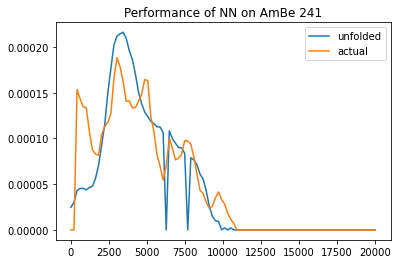

In [43]:
plt.plot(energies, model(np.array([AmBe241DetectorResponse]))[0] / 1e4, label = "unfolded")
plt.plot(energies, AmBe241EnergySpectra, label = "actual")
plt.legend()
plt.title("Performance of NN on AmBe 241")
